In [5]:
'''
Block #1
Shift + Enter to load libraries
'''
import numpy as np
import pandas  as pd
from matplotlib import pyplot as plt
import gym, random, math
from keras.models import Sequential
from keras.optimizers import *
from keras.layers import Dense
import time
from multiprocessing import Process, Queue
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [20]:
'''
Block #2
This block defines the default parameters, Shift + Enter to load parameters
'''
MEMORY_CAPACITY = 1000000 # maximum number of experiences in memory
BATCH_SIZE = 32  # number of experiences drawn from the memory used for training for each step 
GAMMA = 0.99  # discount factor for future reward
MAX_EPSILON = 1.0   # the start epsilon for greedy-epsilon exploration
MIN_EPSILON = 0.05  # the end epsilon 
LAMBDA = 0.00003   # decay factor of exponential decay of epsilon
NUM_LAYER = 2  # number of hidden layers for neural network model
NUM_HIDDEN1 = 64  # number of hidden neurons in the first hidden layer
NUM_HIDDEN2 = 64  # number of hidden neurons in the second hidden layer
ALPHA = 0.001    # learning rate for training model
OPTIMIZER = Adam(lr=ALPHA)    # optimizer for training
LOSS = "mse"   # loss function metrics
CONVERGENCE_THRESHOLD = 220   # threshold used to terminate the training, 
                            # the training will be end if the average reward of the last 100 epochs is larger 
                            # than this threshold, or 1000 epochs have been executed

In [36]:
'''
Block #3
This block contains the major code, Shift + Enter to load code
'''
class Brain:
    ''' 
    This class encapusulates the neural network to approximate the Q function
    '''
    def __init__(self, state_count, action_count):
        self.state_count = state_count
        self.action_count = action_count
        self.model = self.create_model()
        
    def create_model(self):
        '''
        Create the framework of the neural network, the number of hidden layers can be 1 or 2, 
        the activation function is relu for hidden layer/s and is linear for the output layer
        '''
        model = Sequential()
        model.add(Dense(units=NUM_HIDDEN1, activation='relu', input_dim=self.state_count))
        if NUM_LAYER > 1:
            model.add(Dense(units=NUM_HIDDEN2, activation='relu', input_dim=NUM_HIDDEN1))
        model.add(Dense(units=self.action_count, activation='linear'))
        model.compile(loss=LOSS, optimizer=OPTIMIZER)
        return model
    
    def train(self, states, targets, num_epoch=1, verbose=0):
        '''
        Update the model 
        '''
        self.model.fit(states, targets, batch_size=BATCH_SIZE, epochs=num_epoch, verbose=verbose)
    
    def predict(self, states):
        '''
        Predict the action at given state/s using the neural network model
        '''
        if len(states.shape) == 1:
            states = states.reshape(1, self.state_count)
        return self.model.predict(states)
           

class Memory: 
    '''
    This class saves the past experiences capped by the capacity
    '''
    def __init__(self, capacity, states_count):
        self.capacity = capacity
        self.experiences = np.empty((0, states_count*2+2))
    
    def add(self, experience):
        '''
        add a experiences to the memory, the exceed the capacity, remove the oldest one
        '''
        self.experiences = np.vstack((self.experiences, experience))
        
        
        if self.experiences.shape[0] > self.capacity:
            self.experiences = np.delete(self.experiences, (0), axis=0)
            
    def sample(self, n):
        '''
        randomly draw samples from the memory
        '''
        n = min(n, self.experiences.shape[0])
        return self.experiences[np.random.choice(self.experiences.shape[0], 
                                                 n, replace=False), :]

class Agent:
    '''
    The agent uses the Brain and Memory to interact with the environment
    '''
    def __init__(self, state_count, action_count):
        self.state_count = state_count
        self.action_count = action_count
        self.brain = Brain(state_count, action_count)
        self.memory = Memory(MEMORY_CAPACITY, state_count)
        self.steps = 0
        self.epsilon = MAX_EPSILON
        
    def act(self, state, train_mode=True):
        '''
        Choose an action at a given state. The action can be random or predicted by the brain
        '''
        if random.random() < self.epsilon and train_mode:
            return random.randint(0, self.action_count-1)
        else: 
            return np.argmax(self.brain.predict(state))
    
    def observe(self, experience):
        '''
        Add a experience to the memory and decay epsilon
        '''
        self.memory.add(experience)
        self.steps += 1
        self.epsilon = MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * \
        math.exp(-LAMBDA * self.steps)
        
    def replay(self):
        '''
        Update the model using a batch of experiences randomly drawn from the memory
        '''
        batch = self.memory.sample(BATCH_SIZE)
        states = batch[:, :self.state_count]
        new_states = batch[:, -self.state_count:]
        
        predictions = self.brain.predict(states)
        new_predictions = self.brain.predict(new_states)
        
        targets = np.copy(predictions)
        targets[list(range(targets.shape[0])), 
                list(batch[:,self.state_count].astype(int))] = \
        batch[:,self.state_count+1] + GAMMA * np.max(new_predictions, axis=1)
        none_rows = list(np.sum(new_states, axis=1)==0)
        targets[none_rows, list(batch[none_rows, self.state_count].astype(int))] = \
        batch[none_rows, self.state_count+1]
#         print("targets", targets)
        
        self.brain.train(states, targets)

class Environment:
    '''
    This the wrapper of the Open AI Gym
    '''
    def __init__(self, game):
        self.game = game
        self.environment = gym.make(game)
        self.state_count = self.environment.observation_space.shape[0]
    
    def run(self, agent, train_mode=True):
        '''
        One run is a full episode of the game, the environment is reset at the begining, 
        and the agent interacts with environment until done, where done 
        '''
        
        state = self.environment.reset()
        total_reward = 0
        
        while True:
            
            action = agent.act(state, train_mode=train_mode)
            new_state, reward, done, info = self.environment.step(action)
            
#             print("feedback: ", new_state, reward, done, info)
            if train_mode: 
                if done:
                    new_state = np.zeros(self.state_count)
#                 print('done: ', new_state)

                agent.observe(np.array(list(state)+[action]+[reward]+list(new_state)))              
                agent.replay()
                         
            state = new_state
            total_reward += reward
#             print("check1")
            
            if done:
                break
#         print('e: ', agent.epsilon)
#         print("Total reward: ", total_reward)
        self.environment.close()
#         print("epsilon:", agent.epsilon)
        return total_reward

        
def main(tune=True, process_id=None, title=None, 
         plot_test=False, train_epochs=1000, test_epochs=100):
    '''
    main function that the trains and tests the model
    '''
    game = "LunarLander-v2"
    environment = Environment(game)
    
    state_count = environment.environment.observation_space.shape[0]
    action_count = environment.environment.action_space.n
    
    agent = Agent(state_count, action_count)
    train_rewards = []
    try:
        for _ in range(train_epochs):
            train_rewards  += [environment.run(agent)]
            if sum(train_rewards[-100:])/100 > CONVERGENCE_THRESHOLD:
                break
      
    except:
        environment.environment.close()
        
    finally:
        print(str(process_id) + " Average reward of the last 100 training epochs: ", sum(train_rewards[-100:])/100)         
        plt.plot(train_rewards) 
        plt.plot(pd.DataFrame(train_rewards).rolling(100).mean())
        plt.xlabel("Epoch")
        plt.ylabel("Training reward")
        plt.ylim([(min(train_rewards)//100)*100, (max(train_rewards)//100+1)*100])
        plt.title(title)
        plt.show()
        
        if process_id:
            agent.brain.model.save("LunarLander-vanilla_" + str(process_id)+".h5") 
        if plot_test:
            test_rewards = []
            for trial in range(test_epochs):
                test_rewards += [environment.run(agent, train_mode=False)]
            print(str(process_id) + " Average reward of 100 testing epochs: ", sum(test_rewards)/len(test_rewards))       
            plt.plot([(min(test_rewards)//100)*100, (max(test_rewards)//100+1)*100])
            plt.ylabel("Testing reward")
            plt.xlabel("Epoch")
            plt.ylim([-200, 400])
            plt.title(title)
            plt.show()

W0624 21:05:30.059408 140632837228288 deprecation_wrapper.py:119] From /home/jeolin/anaconda3/envs/jeolin/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0624 21:05:30.064093 140632837228288 deprecation_wrapper.py:119] From /home/jeolin/anaconda3/envs/jeolin/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0624 21:05:30.067113 140632837228288 deprecation_wrapper.py:119] From /home/jeolin/anaconda3/envs/jeolin/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0624 21:05:30.063334 140632837228288 deprecation_wrapper.py:119] From /home/jeolin/anaconda3/envs/jeolin/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is depre

0 Average reward of the last 100 training epochs:  221.34462918869926


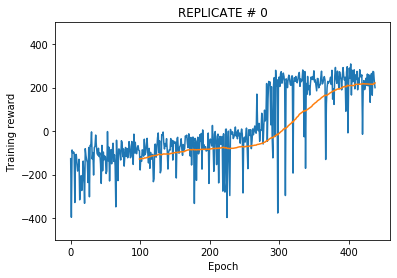

0 Average reward of 100 testing epochs:  231.2649132140571


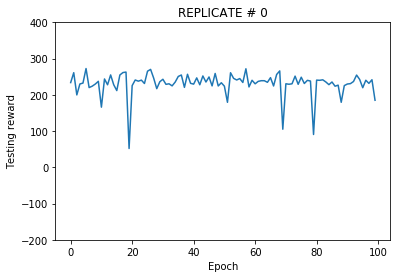

2 Average reward of the last 100 training epochs:  220.3197896374725


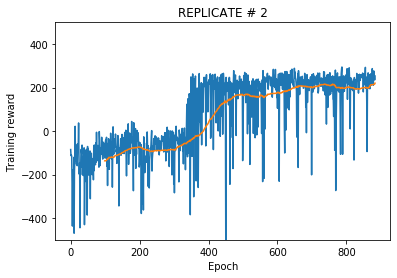

2 Average reward of 100 testing epochs:  234.5009829523481


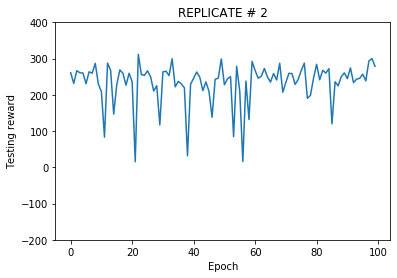

1 Average reward of the last 100 training epochs:  220.49693738592137


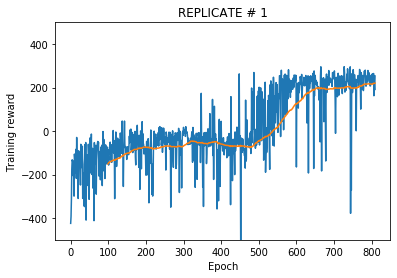

1 Average reward of 100 testing epochs:  247.17649074509464


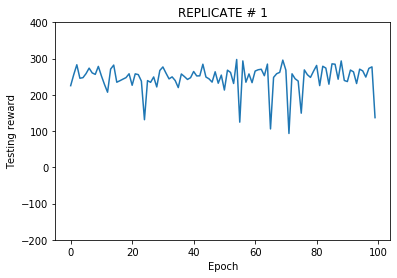

It takes 141.3798711458842 minutes to run 3 replicates of training parallelly


In [4]:
'''
This block produce Figure 1 amd Figure 2 in the report, 3 replicates were executed paralelly
'''

startTime = time.time()
num_process = 3
P = [None] * num_process
for i in range(num_process):
    P[i] = Process(target=main, args=(False, i,"REPLICATE # "+str(i), True,))
    P[i].start()

for i in range(num_process):
    P[i].join()

#mark the end time
endTime = time.time()
#calculate the total time it took to complete the work
workTime =  endTime - startTime
print("It takes " + str(workTime/60) + " minutes to run " + str(num_process) + " replicates of training parallelly")

None Average reward of the last 100 training epochs:  220.1596244733905


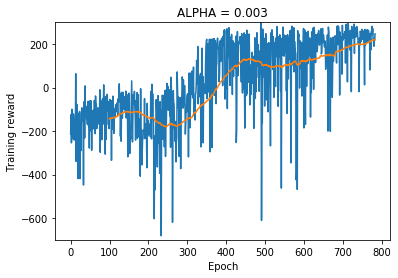

CPU times: user 1h 20s, sys: 26min 19s, total: 1h 26min 40s
Wall time: 1h 22min 39s


In [37]:
'''
This block produce Figure 3 right in the report
'''
# increase learning rate from 0.001 to 0.003
ALPHA = 0.003
OPTIMIZER = Adam(lr=ALPHA)
%time main(title="ALPHA = 0.003")
ALPHA = 0.001
OPTIMIZER = Adam(lr=ALPHA)

None Average reward of the last 100 training epochs:  220.0207663297512


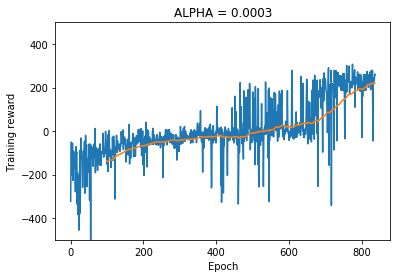

CPU times: user 1h 54min 5s, sys: 1h 15min 19s, total: 3h 9min 24s
Wall time: 3h 2min 57s


In [29]:
'''
This block produce Figure 3 left in the report
'''
# decrease learning rate from 0.001 to 0.0003
ALPHA = 0.0003
OPTIMIZER = Adam(lr=ALPHA)
%time main(title="ALPHA = 0.0003", train_epochs=2000)
ALPHA = 0.001
OPTIMIZER = Adam(lr=ALPHA)

None Average reward of the last 100 training epochs:  162.23021379020983


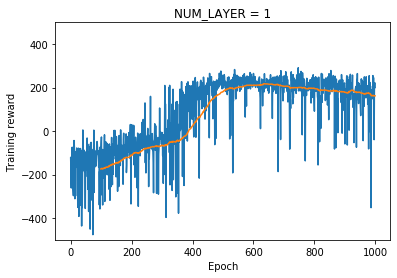

None Average reward of 100 testing epochs:  186.96833328879126
CPU times: user 1h 22min 25s, sys: 45min 12s, total: 2h 7min 38s
Wall time: 2h 3min 50s


In [10]:
'''
This block produce Figure 4 upper left in the report
'''
# 1 hidden layer with 64 neurons
NUM_LAYER = 1
%time main(title="NUM_LAYER = 1")
NUM_LAYER = 2

None Average reward of the last 100 training epochs:  223.28432586550718


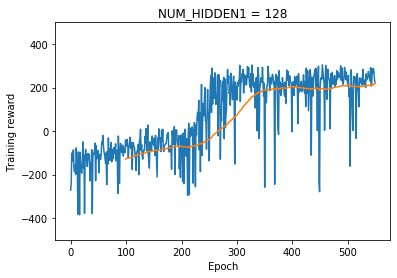

CPU times: user 18min 9s, sys: 1min 4s, total: 19min 14s
Wall time: 17min 5s


In [22]:
'''
This block produce Figure 4 lower left in the report
'''
# increase number of hidden neurons in layer 1 from 64 to 128
NUM_HIDDEN1 = 128
%time main(title="NUM_HIDDEN1 = 128")
NUM_HIDDEN1 = 64

None Average reward of the last 100 training epochs:  220.06636665924736


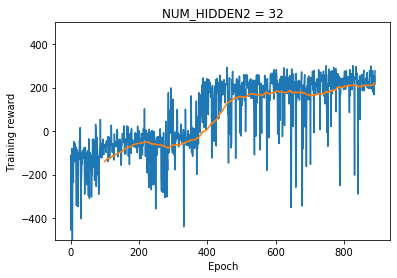

CPU times: user 1h 18min 3s, sys: 45min 35s, total: 2h 3min 38s
Wall time: 1h 58min 45s


In [23]:
'''
This block produce Figure 4 upper right in the report
'''
# decrease number of hidden neurons in layer 2 from 64 to 32
NUM_HIDDEN2 = 32
%time main(title="NUM_HIDDEN2 = 32")
NUM_HIDDEN2 = 64

None Average reward of the last 100 training epochs:  220.50188654587757


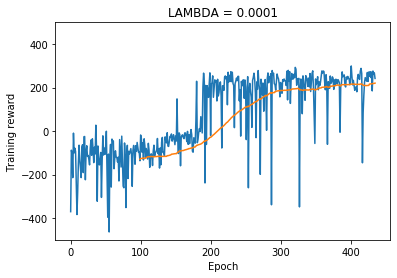

CPU times: user 26min 52s, sys: 3min 41s, total: 30min 33s
Wall time: 27min 54s


In [24]:
'''
This block produce Figure 5 left in the report
'''
# increase lambda resulting in faster decay of epsilon thus less exploration
LAMBDA = 0.0001
%time main(title="LAMBDA = 0.0001")
LAMBDA = 0.00003

None Average reward of the last 100 training epochs:  220.28599826170765


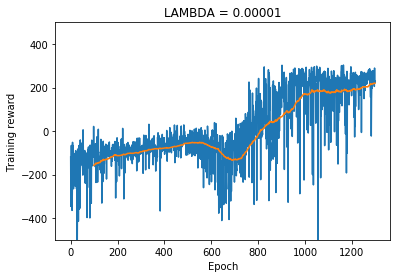

CPU times: user 1h 23min 45s, sys: 49min 17s, total: 2h 13min 2s
Wall time: 2h 7min 46s


In [31]:
'''
This block produce Figure 5 right in the report
'''
# decrease lambda resulting in slower decay of epsilon thus more exploration
LAMBDA = 0.00001
%time main(title="LAMBDA = 0.00001", train_epochs=2000)
LAMBDA = 0.00003

None Average reward of the last 100 training epochs:  200.84644243606738


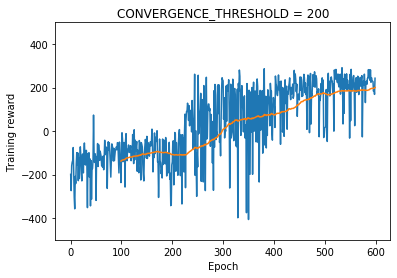

None Average reward of 100 testing epochs:  237.388134000637


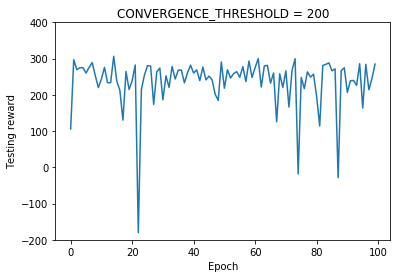

CPU times: user 35min 25s, sys: 9min 23s, total: 44min 48s
Wall time: 41min 33s


In [26]:
'''
This block produce Figure 6 upper in the report
'''
# decrease convergence threshold to terminate training earlier
CONVERGENCE_THRESHOLD = 200
%time main(title="CONVERGENCE_THRESHOLD = 200",plot_test=True)
CONVERGENCE_THRESHOLD = 220

None Average reward of the last 100 training epochs:  240.0362968271143


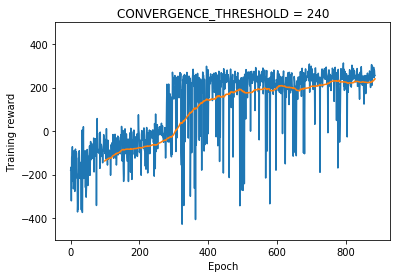

None Average reward of 100 testing epochs:  26.65348489503216


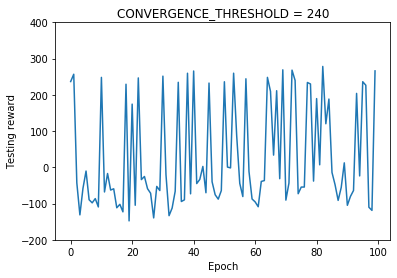

CPU times: user 56min 2s, sys: 24min 5s, total: 1h 20min 7s
Wall time: 1h 16min 7s


In [27]:
'''
This block produce Figure 6 lower in the report
'''
# increase convergence threshold to let the training go longer
CONVERGENCE_THRESHOLD = 240
%time main(title="CONVERGENCE_THRESHOLD = 240", plot_test=True)
CONVERGENCE_THRESHOLD = 220